# LPSpline Demo

This notebook demonstrates how to use the `lpspline` package to build and optimize linear spline models using the additive API.

In [14]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import pimpmyplot as pmp


from lpspline import l, pwl, bs, cs, f, c
from lpspline.viz import splines_diagnostic
from lpspline.constraints import Monotonic, Concave, Convex, Anchor
from lpspline.penalties import Ridge, Lasso

# Set seed for reproducibility
np.random.seed(42)

## Generate Synthetic Data

We create a dataset with various non-linear relationships.

In [2]:
n = 1000
x_linear = np.linspace(0, 10, n)
x_pwl = np.linspace(0, 10, n)
x_bs = np.linspace(0, 10, n)
x_cyc = np.linspace(0, 2*np.pi, n)
x_factor = np.random.randint(0, 3, n)

# True functions
y_linear = -1 * x_linear
y_pwl = np.where(x_pwl < 5, 0, x_pwl - 5) # Hinge at 5
y_bs = np.sin(x_bs) # Sine wave
y_cyc = np.cos(x_cyc) # Cosine wave
y_factor = np.array([0, 2, -1])[x_factor] # Categorical effects

# Combined target with noise
y = (
    y_linear + 
    y_pwl + 
    y_bs + 
    y_cyc + 
    y_factor + 
    np.random.normal(0, 0.2, n)
)

df = pl.DataFrame({
    "xl": x_linear,
    "xpwl": x_pwl,
    "xbs": x_bs,
    "xcyc": x_cyc,
    "xfactor": x_factor,
    "target": y
})

print(df.head())

shape: (5, 6)
┌─────────┬─────────┬─────────┬──────────┬─────────┬──────────┐
│ xl      ┆ xpwl    ┆ xbs     ┆ xcyc     ┆ xfactor ┆ target   │
│ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---     ┆ ---      │
│ f64     ┆ f64     ┆ f64     ┆ f64      ┆ i64     ┆ f64      │
╞═════════╪═════════╪═════════╪══════════╪═════════╪══════════╡
│ 0.0     ┆ 0.0     ┆ 0.0     ┆ 0.0      ┆ 2       ┆ 0.009704 │
│ 0.01001 ┆ 0.01001 ┆ 0.01001 ┆ 0.006289 ┆ 0       ┆ 0.83379  │
│ 0.02002 ┆ 0.02002 ┆ 0.02002 ┆ 0.012579 ┆ 2       ┆ 0.054011 │
│ 0.03003 ┆ 0.03003 ┆ 0.03003 ┆ 0.018868 ┆ 2       ┆ -0.01023 │
│ 0.04004 ┆ 0.04004 ┆ 0.04004 ┆ 0.025158 ┆ 0       ┆ 0.951883 │
└─────────┴─────────┴─────────┴──────────┴─────────┴──────────┘


## 2. Define API and Model

We define the components and add them together to create the model.

In [3]:
# Create model using additive syntax
model = (
    +l(term='xl', bias=True)
    + pwl(term='xpwl', knots=[5.])
    + bs(term="xbs", knots=np.linspace(-5, 15, 10), degree=3)
    + cs(term="xcyc", period=2*np.pi, order=2)
    + f(term="xfactor", n_classes=3)
)

## 3. Fit the Model

We use the `fit` method on the combined model.

In [4]:
model.fit(df, df["target"])

print("Model fitted successfully.")


✨ Model Summary ✨
Problem Status: ✅ optimal
------------------------------------------------------------------------------------------------------------------------
Spline Type          | Term         | Tag             | Constraints          | Penalties            | Params  
------------------------------------------------------------------------------------------------------------------------
🟢 Linear            | xl           | linear          | None                 | None                 | 2       
🟢 PiecewiseLinear   | xpwl         | pwl             | None                 | None                 | 3       
🟢 BSpline           | xbs          | bspline         | None                 | None                 | 12      
🟢 CyclicSpline      | xcyc         | cyclicspline    | None                 | None                 | 5       
🟢 Factor            | xfactor      | factor          | None                 | None                 | 3       
----------------------------------------------------

(<Figure size 1500x800 with 5 Axes>,
 array([<Axes: xlabel='xl'>, <Axes: xlabel='xpwl'>, <Axes: xlabel='xbs'>,
        <Axes: xlabel='xcyc'>, <Axes: xlabel='xfactor'>, <Axes: >],
       dtype=object))

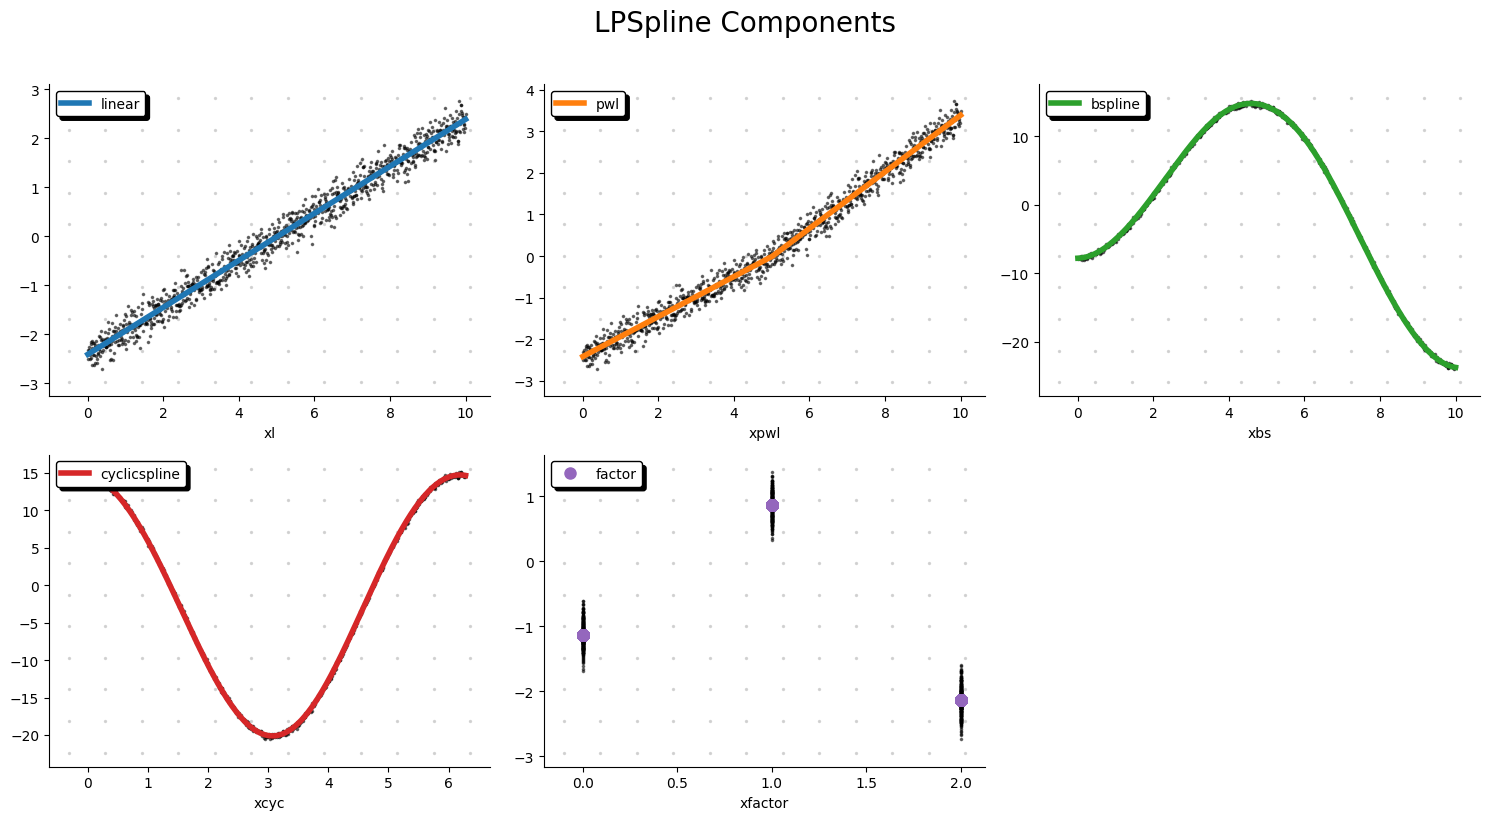

In [5]:
splines_diagnostic(model=model, X=df, ncols=3, y=df['target'])

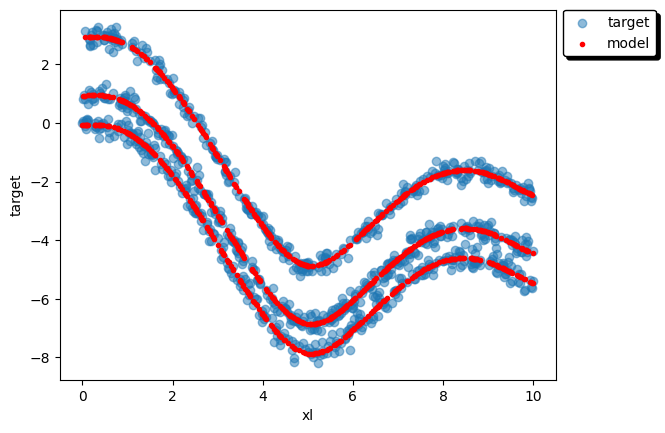

In [26]:
plt.scatter(df['xl'], df['target'], alpha=.5, label='target')
plt.scatter(df['xl'], model.predict(df), marker='.', color='red', label='model')
plt.ylabel('target')
plt.xlabel('xl')
pmp.legend(loc='ext side upper right')